In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random
import time

import torch
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.optim as optim
import os
from google.colab import drive

In [6]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
# Replace '------' with the path such that "ITCS_6010_8010_assignment1" is your working directory
%cd '/content/gdrive/My Drive/data'

/content/gdrive/My Drive/data


In [8]:
data_dir = '/content/gdrive/My Drive/data/'

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
# Define the MoCo model
class MoCo(nn.Module):
    def __init__(self, base_encoder, dim=128, K=131072, m=0.999, T=0.07):
        super(MoCo, self).__init__()

        self.K = K  # Size of the queue
        self.m = m  # Momentum coefficient
        self.T = T  # Temperature for contrastive loss

        # Create the query encoder
        self.encoder_q = base_encoder(num_classes=dim)
        self.encoder_k = base_encoder(num_classes=dim)

        # Initialize the momentum encoder with the same weights
        self._init_momentum_encoder()

        # Create the queue
        self.register_buffer("queue", torch.randn(dim, K))
        self.queue = nn.functional.normalize(self.queue, dim=0)
        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))

    def _init_momentum_encoder(self):
        # Initialize momentum encoder parameters to match the query encoder
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data.copy_(param_q.data)  # Copy weights
            param_k.requires_grad = False  # Do not update momentum encoder with gradients

    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        # Update the momentum encoder with momentum
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1. - self.m)

    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
        # Update the queue
        batch_size = keys.shape[0]  # Use the actual batch size

        ptr = int(self.queue_ptr)
        assert self.K % batch_size == 0 or batch_size <= self.K  # Ensure the batch size fits in the queue

        # Replace the keys at ptr (dequeue and enqueue), handling small batches correctly
        end_ptr = min(ptr + batch_size, self.K)
        effective_batch_size = end_ptr - ptr

        self.queue[:, ptr:end_ptr] = keys[:effective_batch_size].T  # Dequeue and enqueue the keys
        ptr = (ptr + effective_batch_size) % self.K  # Move the pointer

        self.queue_ptr[0] = ptr

    def forward(self, im_q, im_k):
        # Compute query features
        q = self.encoder_q(im_q)  # Query image
        q = F.normalize(q, dim=1)

        # Compute key features using momentum encoder
        with torch.no_grad():
            self._momentum_update_key_encoder()  # Update the key encoder
            k = self.encoder_k(im_k)  # Key image
            k = F.normalize(k, dim=1)

        # Compute logits and contrastive loss
        # Positive logits: dot product between query and key
        l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)

        # Negative logits: dot product between query and all negatives in the queue
        l_neg = torch.einsum('nc,ck->nk', [q, self.queue.clone().detach()])

        # Logits: [N, 1 + K]
        logits = torch.cat([l_pos, l_neg], dim=1)

        # Apply temperature scaling
        logits /= self.T

        # Labels: positive key is the first in the logit list
        labels = torch.zeros(logits.shape[0], dtype=torch.long).to(im_q.device)

        # Dequeue and enqueue the current mini-batch of keys
        self._dequeue_and_enqueue(k)

        return logits, labels


In [11]:
# Data augmentation for self-supervised learning (MoCo-style augmentations)
ssl_augment = transforms.Compose([
    transforms.RandomResizedCrop(128, scale=(0.2, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomRotation(20),  # Rotate the image by up to 20 degrees
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Custom Dataset for SimCLR (MoCo) with two augmented views
class SimCLRDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.transform = ssl_augment

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]

        # If the image is already a tensor, convert it to a PIL Image for transformations
        if isinstance(img, torch.Tensor):
            img = transforms.ToPILImage()(img)

        # Apply augmentations to create two different views of the same image
        img1 = self.transform(img)
        img2 = self.transform(img)

        return img1, img2, label


In [12]:
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'train/'))

# Create the SimCLRDataset with augmentations
ssl_train_dataset = SimCLRDataset(train_dataset)

# Create the DataLoader for SSL pre-training
ssl_train_loader = DataLoader(ssl_train_dataset, batch_size=64, shuffle=True, num_workers=4)


In [13]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Skip connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity  # Add skip connection (residual)
        return F.relu(out)

# Define the ResNetCNN model with Dropout (used as the base encoder)
class ResNetCNN(nn.Module):
    def __init__(self, num_classes=16):  # Adjust num_classes based on your dataset
        super(ResNetCNN, self).__init__()
        self.layer1 = ResidualBlock(3, 64)  # Start with 3 channels (RGB input)
        self.layer2 = ResidualBlock(64, 128, stride=2)
        self.layer3 = ResidualBlock(128, 256, stride=2)
        self.layer4 = ResidualBlock(256, 512, stride=2)
        self.fc = nn.Linear(512 * 16 * 16, 128)  # MoCo latent dimension
        self.classifier = nn.Sequential(
            nn.Linear(128, num_classes),  # Add classifier layer
            nn.Dropout(0.5)  # 50% dropout to avoid overfitting
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)  # Pass through MoCo latent fc layer
        return x

    def forward_for_classification(self, x):
        x = self.forward(x)  # Get the output from the encoder
        x = self.classifier(x)  # Pass through the classification layer
        return x

# Initialize the MoCo model with a larger queue size
moco_model = MoCo(ResNetCNN, dim=128, K=131072, m=0.999, T=0.07).to(device)
criterion = nn.CrossEntropyLoss()

# Optimizer and scheduler for MoCo pre-training
optimizer = torch.optim.SGD(moco_model.parameters(), lr=0.03, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

# MoCo pre-training loop (self-supervised learning)
for epoch in range(400):
    moco_model.train()
    running_loss = 0.0

    for img1, img2, _ in ssl_train_loader:
        img1, img2 = img1.to(device), img2.to(device)

        logits, labels = moco_model(img1, img2)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    scheduler.step()  # Adjust the learning rate
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(ssl_train_loader)}')

Epoch 1, Loss: 6.305477230172408
Epoch 2, Loss: 8.040267793755783
Epoch 3, Loss: 8.615648897070633
Epoch 4, Loss: 8.975737245459305
Epoch 5, Loss: 9.239487848783794
Epoch 6, Loss: 9.447888098264995
Epoch 7, Loss: 9.619960032011333
Epoch 8, Loss: 9.766709327697754
Epoch 9, Loss: 9.894431465550474
Epoch 10, Loss: 10.007546826412803
Epoch 11, Loss: 10.108657836914062
Epoch 12, Loss: 10.200853448165091
Epoch 13, Loss: 10.284540803808914
Epoch 14, Loss: 10.362383817371569
Epoch 15, Loss: 10.433955242759303
Epoch 16, Loss: 10.501537247707969
Epoch 17, Loss: 10.563437637529875
Epoch 18, Loss: 10.621902139563309
Epoch 19, Loss: 10.675293822037546
Epoch 20, Loss: 10.729433687109696
Epoch 21, Loss: 10.778014459108052
Epoch 22, Loss: 10.824858916433234
Epoch 23, Loss: 10.871374280829178
Epoch 24, Loss: 10.912921478873805
Epoch 25, Loss: 10.953739618000231
Epoch 26, Loss: 10.992458243119088
Epoch 27, Loss: 11.02742842624062
Epoch 28, Loss: 11.065469214790745
Epoch 29, Loss: 11.09679106662148
Epoch

In [14]:
# Fine-tuning transformations with mild augmentations
classification_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),  # Flip the image horizontally with a probability of 50%
    transforms.RandomRotation(10),  # Rotate the image slightly by up to 10 degrees
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Apply the transformation to your labeled classification dataset
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'train/'), transform=classification_transform)

# Create DataLoader for the classification task
trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)

In [15]:
# Define the transformations for validation/testing
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Assuming you have a test/validation dataset in the same format as your training data
test_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'test/'), transform=test_transform)

# Create DataLoader for test
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)


In [16]:
# Evaluation function
def evaluate_model(model, testloader, criterion):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation for inference
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass through the query encoder and classification layer
            outputs = model.encoder_q.forward_for_classification(inputs)

            # Compute loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(testloader)
    accuracy = 100 * correct / total
    print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%')
    return avg_loss, accuracy

In [25]:
# Re-initialize the optimizer and scheduler for fine-tuning
optimizer = optim.Adam(moco_model.encoder_q.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40)

train_losses = []
test_losses = []
num_epochs = 30

# Fine-tuning loop on the labeled data
for epoch in range(num_epochs):
    moco_model.encoder_q.train()
    running_loss = 0.0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass through the query encoder and classification layer
        outputs = moco_model.encoder_q.forward_for_classification(inputs)  # Use forward_for_classification

        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(trainloader)
    train_losses.append(avg_train_loss)

    #Evaluate on the test set to compute test loss for the current epoch
    avg_test_loss, _ = evaluate_model(moco_model, testloader, criterion)
    test_losses.append(avg_test_loss)

    # Print losses for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

    scheduler.step()  # Adjust the learning rate

Test Loss: 1.2711, Test Accuracy: 67.00%
Epoch [1/30], Train Loss: 2.2571, Test Loss: 1.2711
Test Loss: 1.2962, Test Accuracy: 66.25%
Epoch [2/30], Train Loss: 2.2490, Test Loss: 1.2962
Test Loss: 1.1251, Test Accuracy: 69.00%
Epoch [3/30], Train Loss: 2.2051, Test Loss: 1.1251
Test Loss: 1.2066, Test Accuracy: 66.50%
Epoch [4/30], Train Loss: 2.2983, Test Loss: 1.2066
Test Loss: 1.2692, Test Accuracy: 64.75%
Epoch [5/30], Train Loss: 2.2990, Test Loss: 1.2692
Test Loss: 1.2084, Test Accuracy: 68.25%
Epoch [6/30], Train Loss: 2.2400, Test Loss: 1.2084
Test Loss: 1.2082, Test Accuracy: 67.00%
Epoch [7/30], Train Loss: 2.2460, Test Loss: 1.2082
Test Loss: 1.3752, Test Accuracy: 66.25%
Epoch [8/30], Train Loss: 2.2385, Test Loss: 1.3752
Test Loss: 1.2808, Test Accuracy: 65.25%
Epoch [9/30], Train Loss: 2.1029, Test Loss: 1.2808
Test Loss: 1.2393, Test Accuracy: 68.25%
Epoch [10/30], Train Loss: 2.2268, Test Loss: 1.2393
Test Loss: 1.3104, Test Accuracy: 66.50%
Epoch [11/30], Train Loss: 2

In [26]:
# Save the trained model
def save_model(model, path="moco_model.pth"):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

save_model(moco_model)

Model saved to moco_model.pth


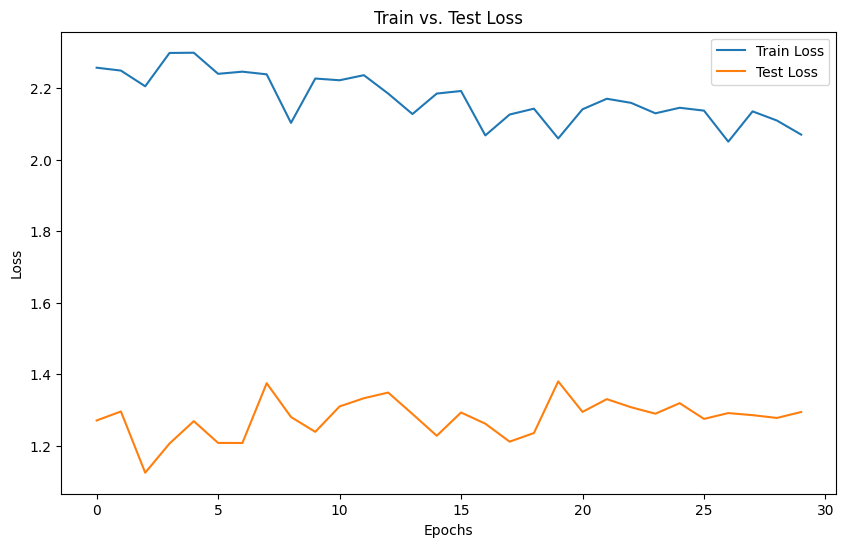

In [27]:
#Function to plot train vs. test loss
def plot_losses(train_losses, test_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train vs. Test Loss")
    plt.legend()
    plt.show()

plot_losses(train_losses, test_losses)
